In [1]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano

In [2]:
with open('seasons.pickle') as f:
    seasons = pickle.load(f)
for year, season in seasons.iteritems():
    print year,
    season.load_scores()

2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018


In [127]:
ELT_TYPES_MEN = ('ch', 'st', 'sp', '1j', '2j', '3j', '4j')
PRIORS_MEN = (('sp', 2.5, 0.5), ('ch', 2., 0.5), ('st', 3., 0.5),
                  ('1j', 0.67, 0.01), ('2j', 4., 0.5), ('3j', 6., 0.7), ('4j', 10.5, 1.0))
ELT_TYPES_LADIES = ('ch', 'st', 'sp', '1j', '2j', '3j')
PRIORS_LADIES = (('sp', 2.5, 0.5), ('ch', 2., 0.5), ('st', 3., 0.5),
                     ('1j', 0.67, 0.01), ('2j', 4., 0.5), ('3j', 6., 0.7))
ELT_TYPES_PAIRS = ('st', 'sp', 'tw', 'th', 'li', 'ds', 'ch', 'ju')
PAIR_PRIORS = (('st', 3.0, 0.5), ('sp', 3.5, 0.5), ('tw', 5.0, 1.0), ('th', 4.0, 1.0),
               ('li', 6.0, 0.7), ('ds', 4.0, 0.5), ('ch', 2.0, 0.5), ('ju', 3.0, 1.0))
ELT_TYPES_DANCE = ('tw', 'st', 'pd', 'li', 'l2', 'sp', 'ch')
DANCE_PRIORS = (('tw', 6.0, 1.0), ('st', 7.0, 1.0), ('pd', 4.0, 0.5), ('li', 4.0, 0.5), 
                ('l2', 8.0, 0.5), ('sp', 4.0, 0.5), ('ch', 2.0, 0.5))

In [128]:
DISCIPLINE = 'dance'
ELT_TYPES = ELT_TYPES_DANCE
ELT_PRIORS = DANCE_PRIORS

In [129]:
elements = pd.read_csv('pd_data/elements_' + DISCIPLINE + '.csv')
components = pd.read_csv('pd_data/components_summary_' + DISCIPLINE + '.csv')
elements18 = pd.read_csv('pd_data/elements_' + DISCIPLINE + '18all.csv')
components18 = pd.read_csv('pd_data/components_summary_' + DISCIPLINE + '18all.csv')
elements = pd.concat([elements, elements18])
components = pd.concat([components, components18])
elements.date = elements.date.astype('datetime64[ns]')
components.date = components.date.astype('datetime64[ns]')

In [130]:
skaters = sorted(elements.skater.unique())
num_skaters = len(skaters)
skater_lookup = dict(zip(skaters, xrange(len(skaters))))

In [131]:
skater_start = {}
for skater in elements.skater.unique():
    skater_elts = elements[elements.skater == skater]
    skater_start[skater] = skater_elts.date.unique()[0]

In [132]:
elements['weeks_since_skater_start'] = elements.apply(lambda row: row.date - skater_start[row.skater], axis=1).astype('timedelta64[W]')
components['weeks_since_skater_start'] = components.apply(lambda row: row.date - skater_start[row.skater], axis=1).astype('timedelta64[W]')

In [133]:
overall_start = elements.date.unique()[0]
elements['weeks_since_overall_start'] = elements.apply(lambda row: row.date - overall_start, axis=1).astype('timedelta64[W]')
components['weeks_since_overall_start'] = components.apply(lambda row: row.date - overall_start, axis=1).astype('timedelta64[W]')

In [134]:
elements.index = list(xrange(len(elements)))
components.index = list(xrange(len(components)))

In [135]:
elements['log_skater_start'] = elements.apply(lambda row: -1 if row.weeks_since_skater_start == 0
                                                          else np.log(row.weeks_since_skater_start), axis=1)
elements['log_overall_start'] = elements.apply(lambda row: -1 if row.weeks_since_overall_start == 0
                                                           else np.log(row.weeks_since_overall_start), axis=1)
components['log_skater_start'] = components.apply(lambda row: -1 if row.weeks_since_skater_start == 0
                                                                 else np.log(row.weeks_since_skater_start), axis=1)
components['log_overall_start'] = elements.apply(lambda row: -1 if row.weeks_since_overall_start == 0
                                                             else np.log(row.weeks_since_overall_start), axis=1)

In [136]:
results = {}  # dict of (trace, model, theano shared)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1496/1500 [00:29<00:00, 50.89it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.636357335693, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 276 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
1

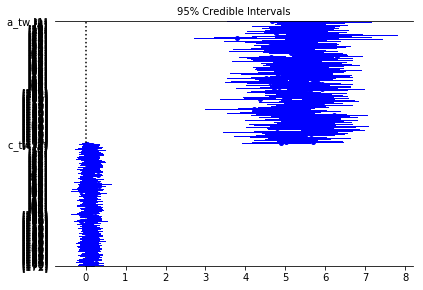

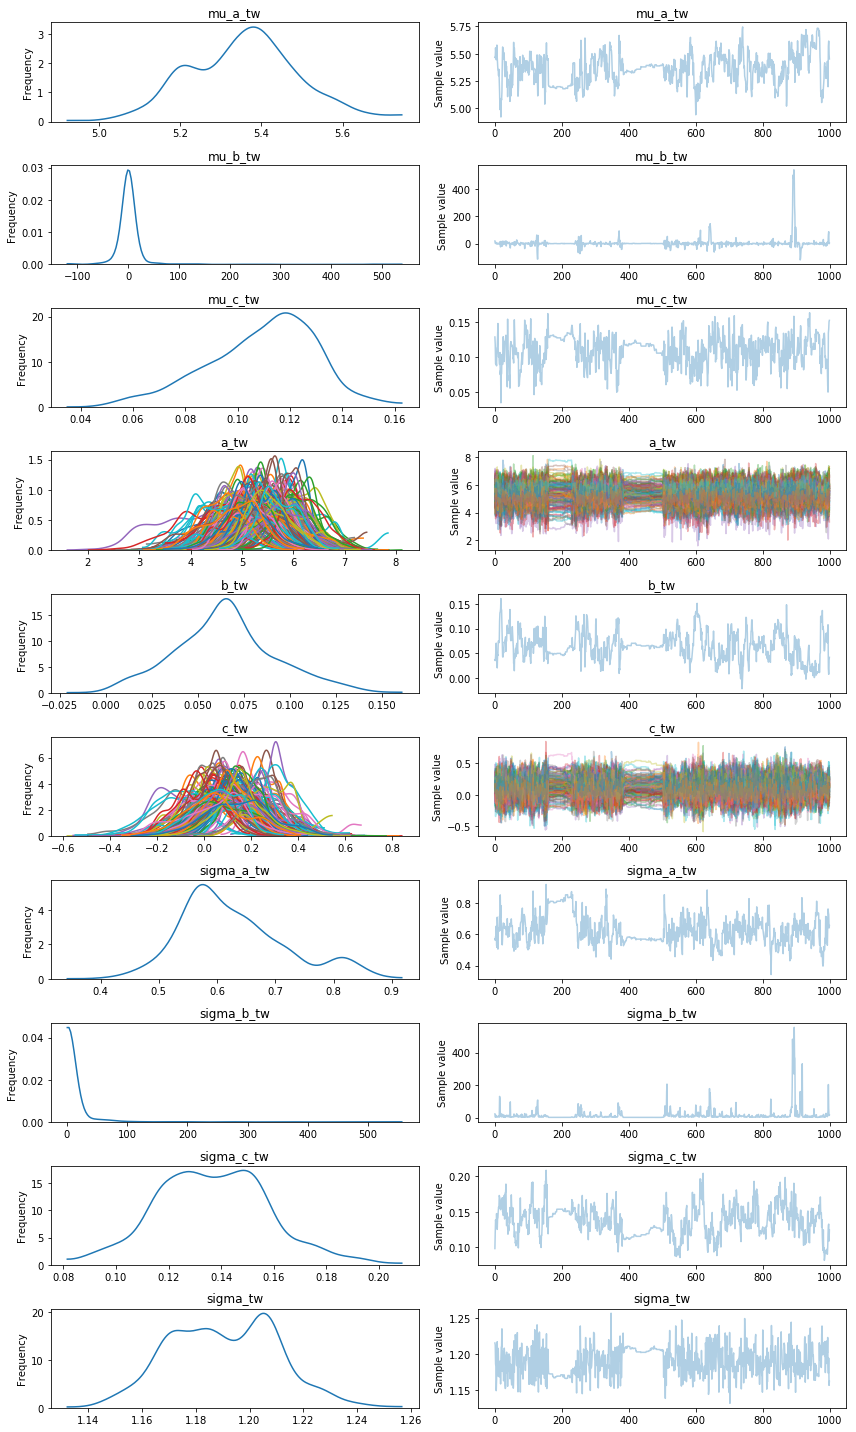

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1494/1500 [00:35<00:00, 42.27it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.69069912119, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 152 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:35<00:00, 42.31it/s]


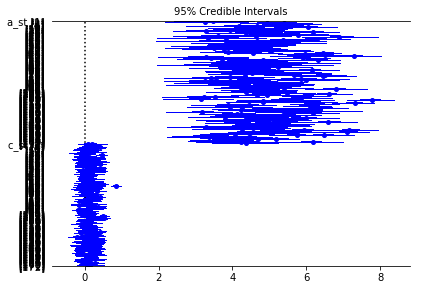

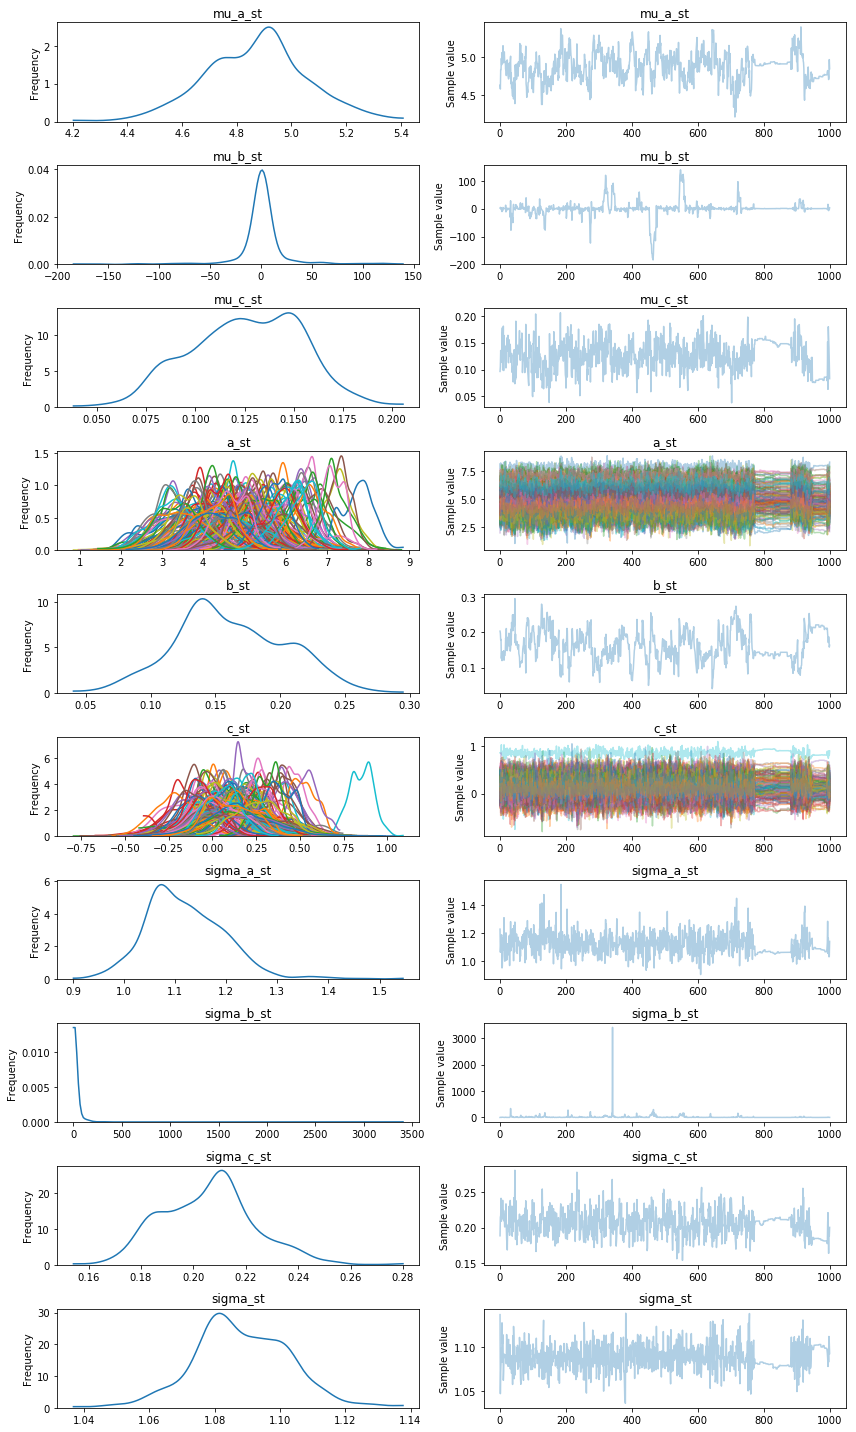

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1498/1500 [00:20<00:00, 71.63it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 88 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:20<00:00, 71.63it/s]


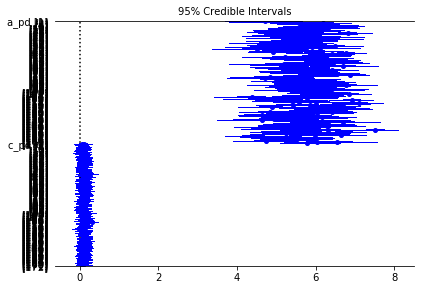

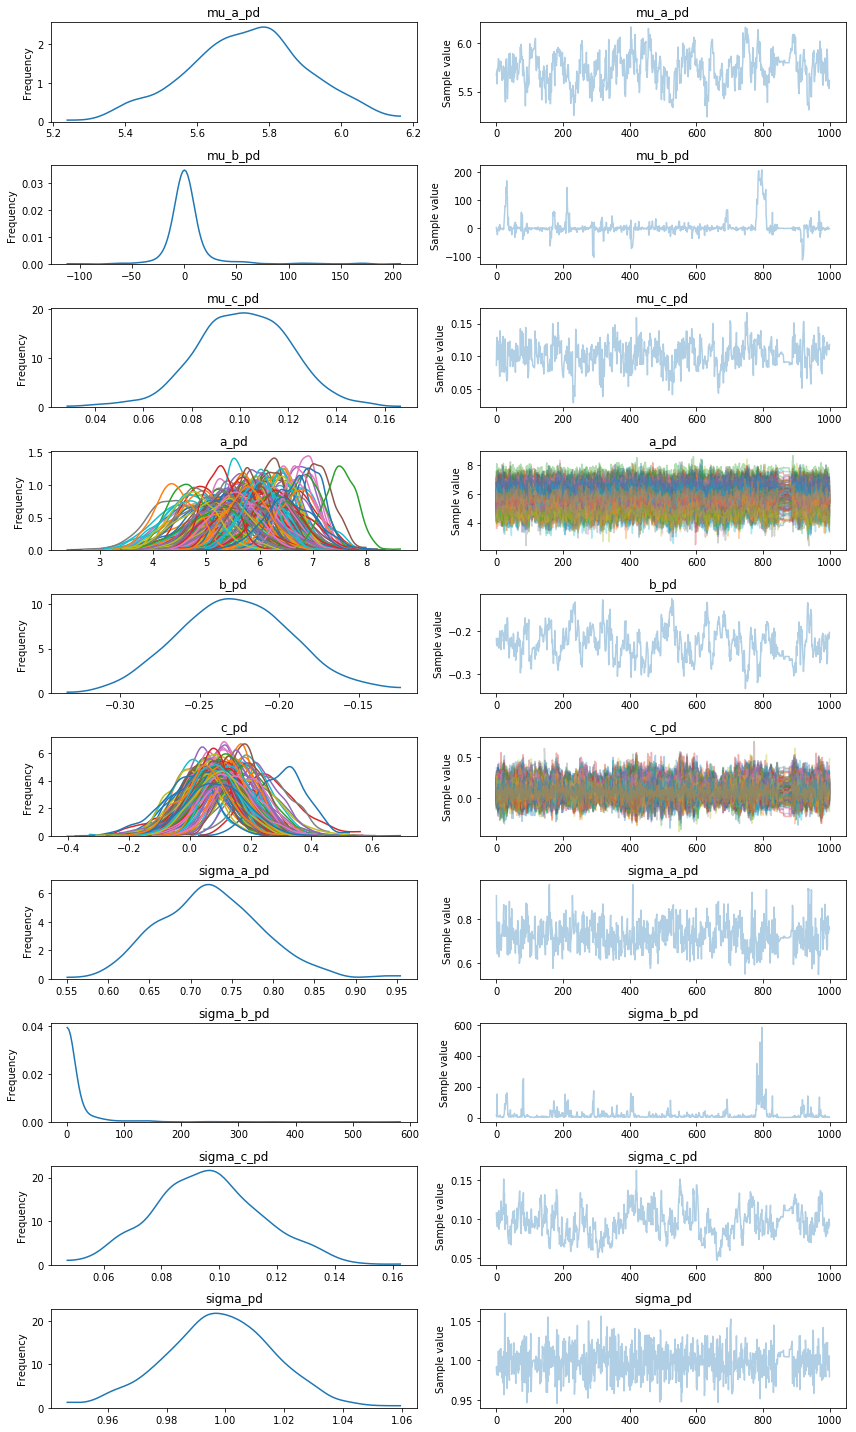

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1493/1500 [00:29<00:00, 49.82it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 94 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:30<00:00, 49.90it/s]


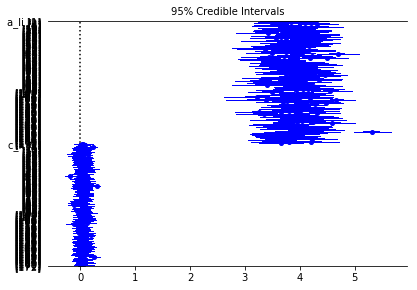

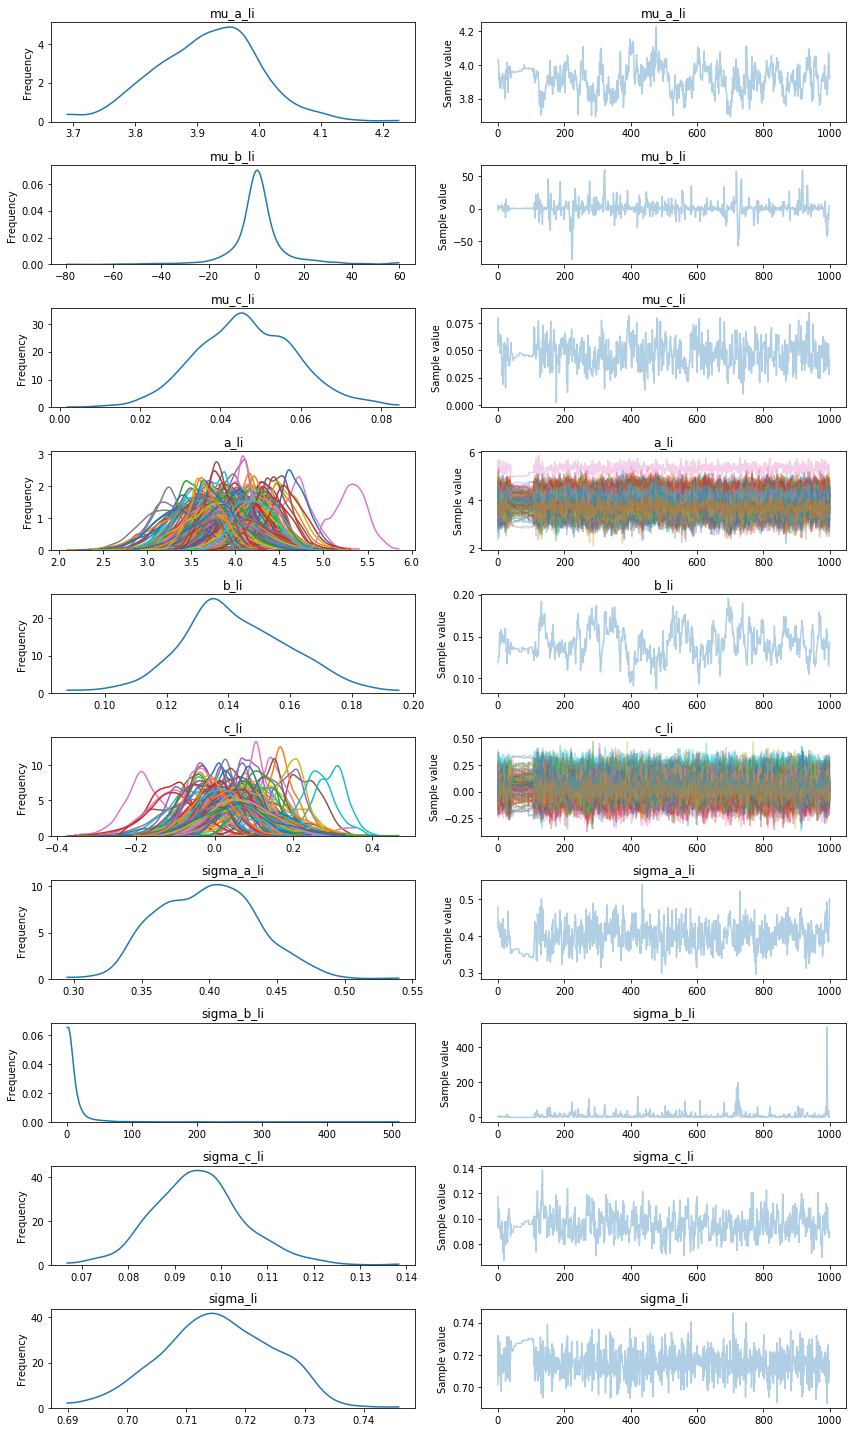

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:16<00:00, 93.28it/s]


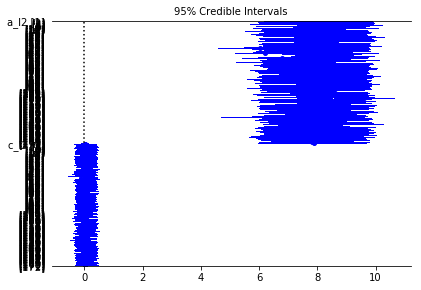

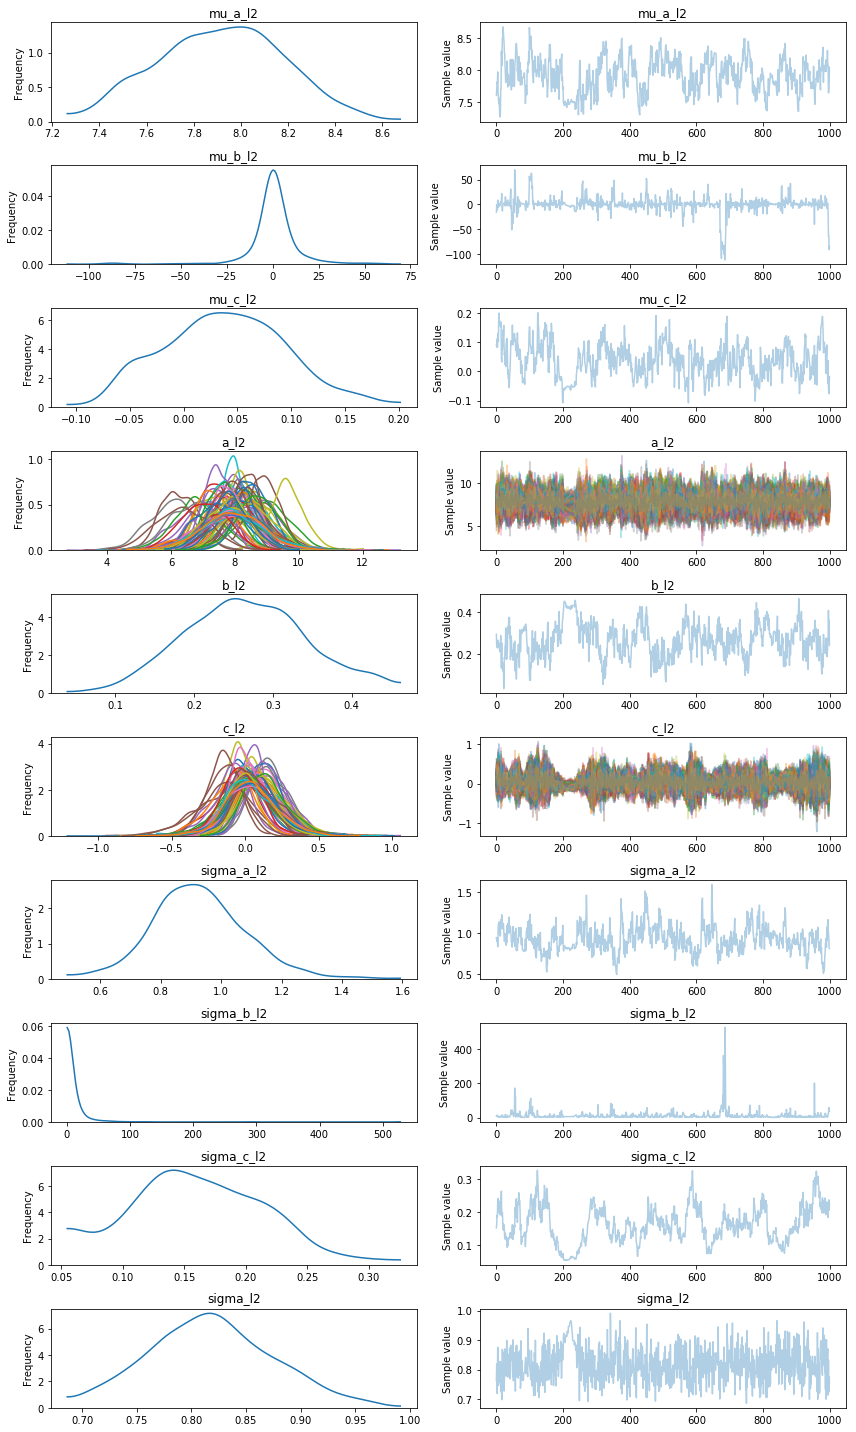

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:17<00:00, 84.82it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.669145576836, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 138 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



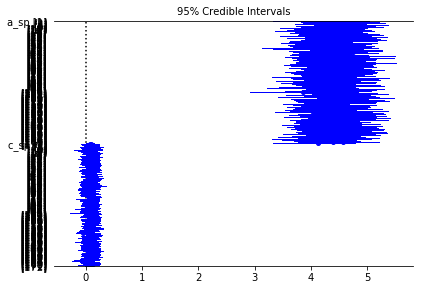

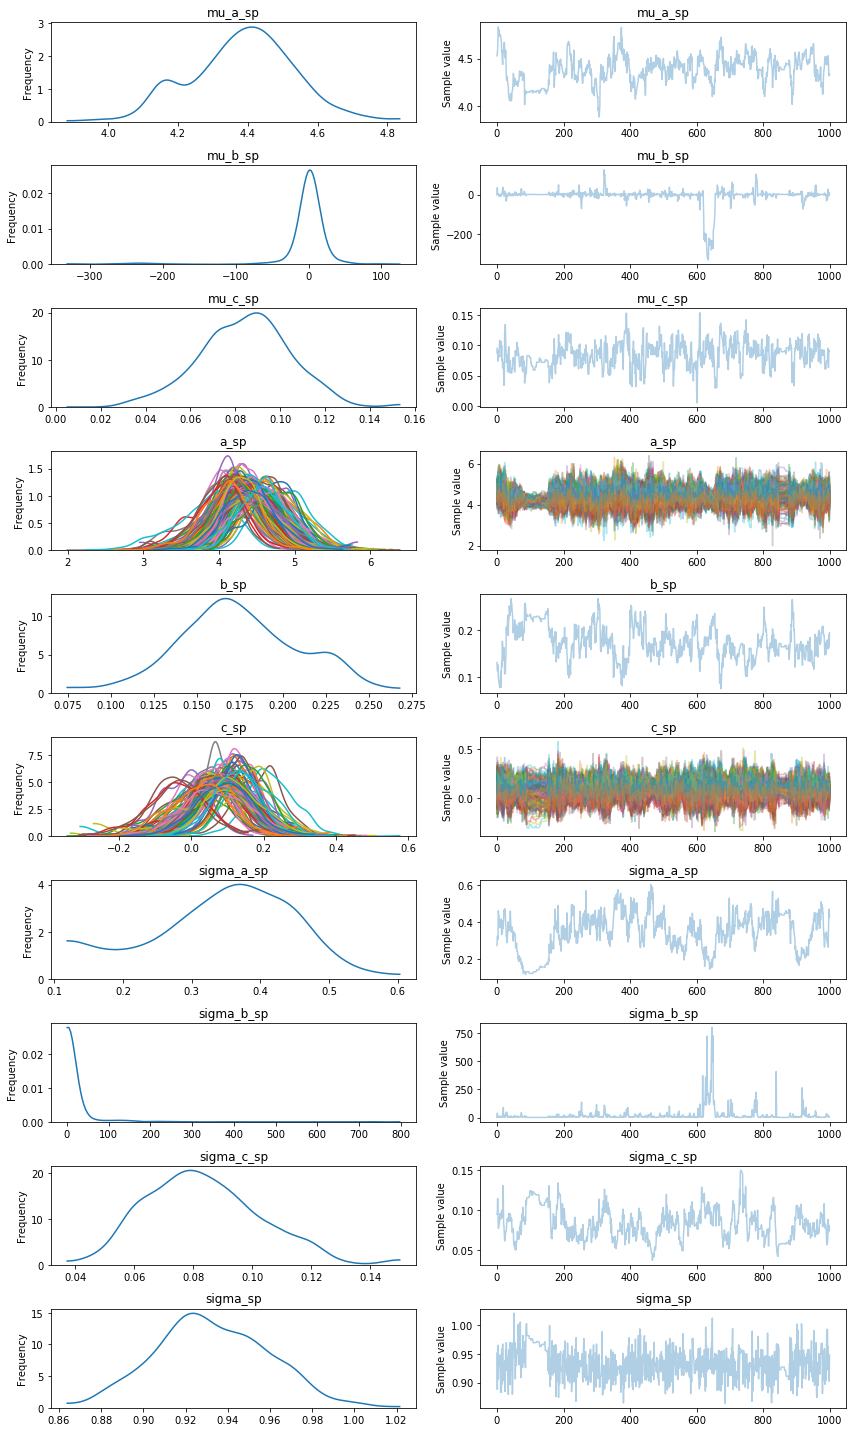

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1495/1500 [00:47<00:00, 31.56it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 29 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:47<00:00, 31.61it/s]


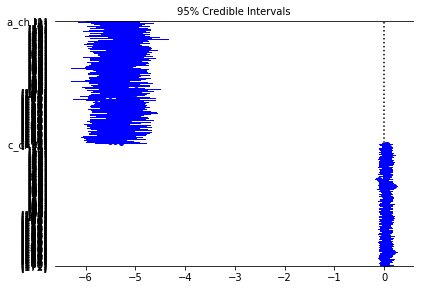

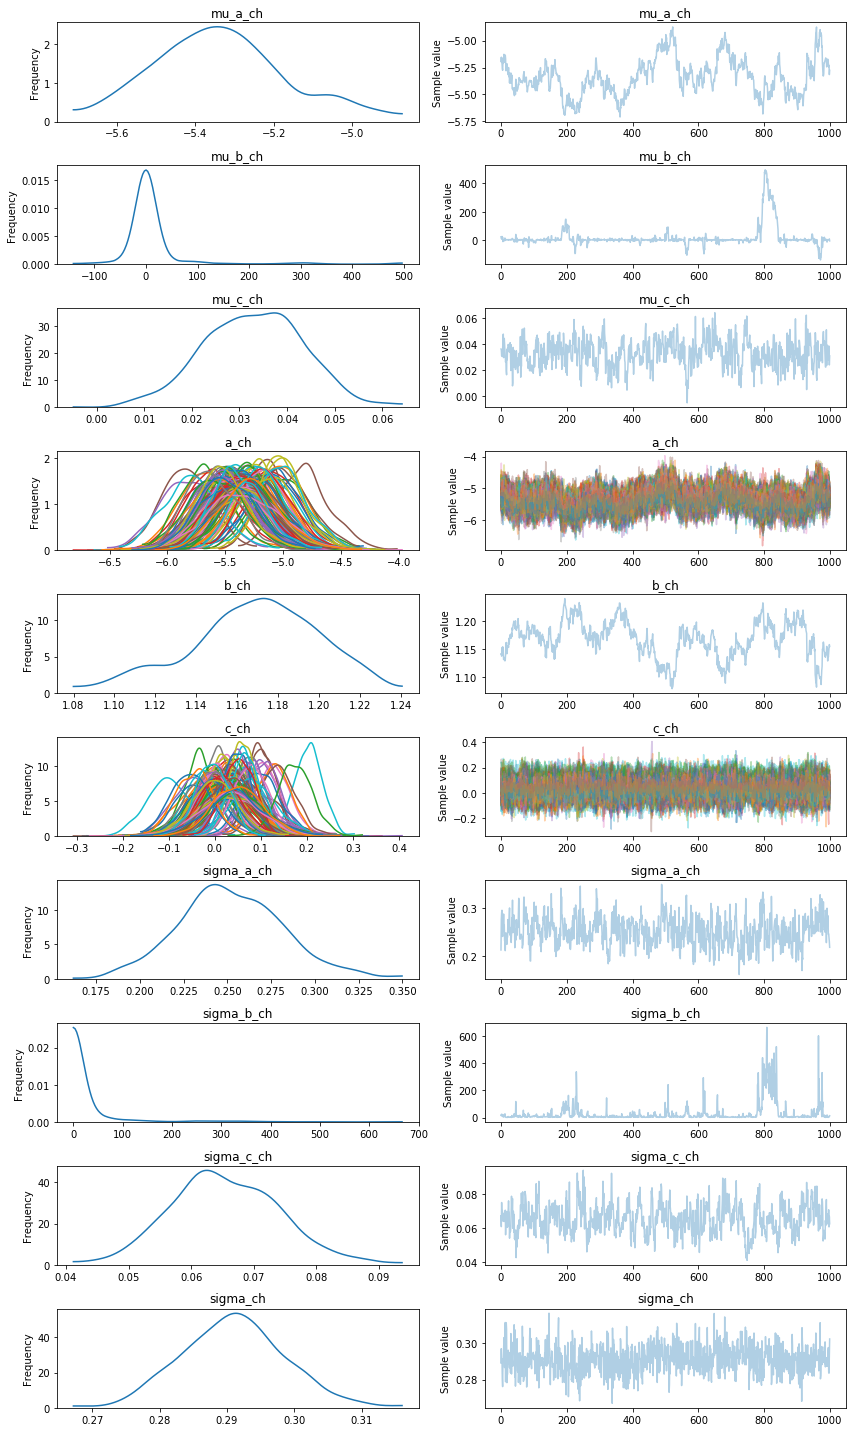

In [137]:
for elt_type, prior_mu, prior_sd in ELT_PRIORS:
    elts = elements[elements.elt_type == elt_type]
    
    # Predictors/group indicators.
    skater = elts['skater_code'] = elts.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    start_overall = np.asarray(elts.log_overall_start)
    start_overall = theano.shared(start_overall)
    start_skater = np.asarray(elts.log_skater_start)
    start_skater = theano.shared(start_skater)
    
    points = elts.points
    
    model = pm.Model()
    with model:
        # Prior on group distribution.
        mu_a = pm.Normal('mu_a_' + elt_type, prior_mu, sd=prior_sd)
        sigma_a = pm.HalfCauchy('sigma_a_' + elt_type, 5)
        mu_b = pm.Normal('mu_b_' + elt_type, mu=0., sd=1e5)
        sigma_b = pm.HalfCauchy('sigma_b_' + elt_type, 5)
        mu_c = pm.Normal('mu_c_' + elt_type, mu=0., sd=1e5)
        sigma_c = pm.HalfCauchy('sigma_c_' + elt_type, 5)
        
        # Group distribution.
        a = pm.Normal('a_' + elt_type, mu_a, sd=sigma_a, shape=num_skaters)
        b = pm.Normal('b_' + elt_type, mu_b, sd=sigma_b)
        c = pm.Normal('c_' + elt_type, mu_c, sd=sigma_c, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + elt_type, 5)
        
        y_hat = a[skater] + b * start_overall + c[skater] * start_skater
        
        # Data model.
        y = pm.Normal('y_' + elt_type, y_hat, sd=sigma, observed=points)

    # Fit the model.
    with model:
        trace = pm.sample(draws=1000, tune=500)
        
    # Save the results.
    results[elt_type] = (trace, model, (skater, start_overall, start_skater))
    
    # Visualize fit.
    pm.forestplot(trace, varnames=['a_' + elt_type, 'c_' + elt_type])
    pm.traceplot(trace)
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [01:29<00:00, 11.12it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 31 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



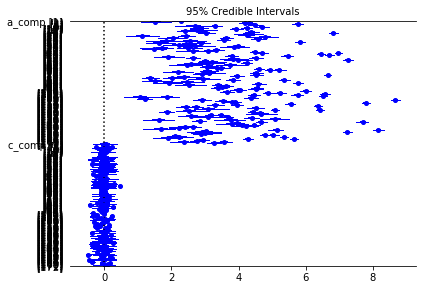

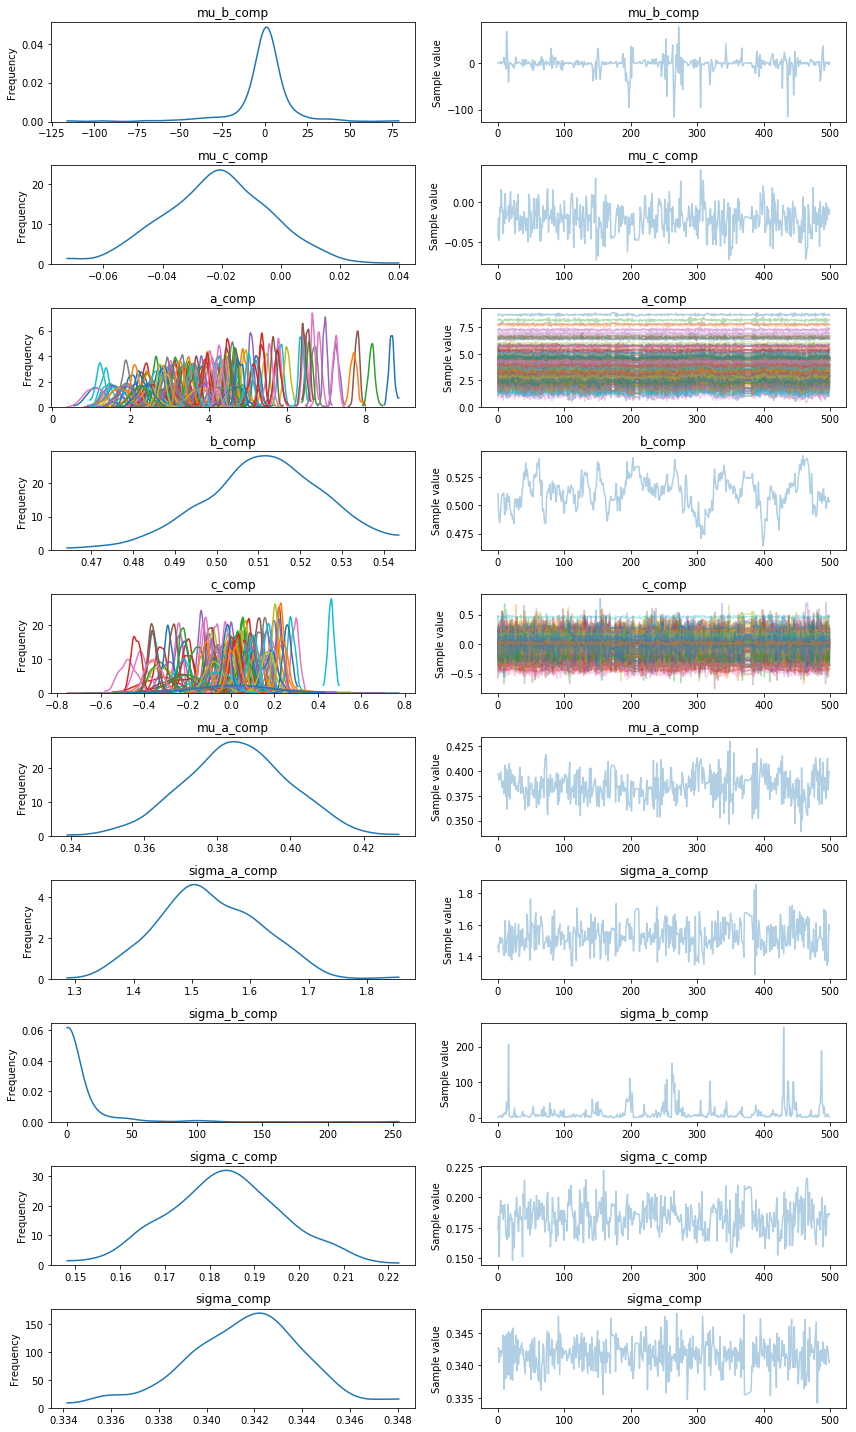

In [138]:
skater = components['skater_code'] = components.skater.replace(skater_lookup).values
skater = theano.shared(skater)
start_overall = np.asarray(components.log_overall_start)
start_overall = theano.shared(start_overall)
start_skater = np.asarray(components.log_skater_start)
start_skater = theano.shared(start_skater)

points = components.points

model = pm.Model()
with model:
    # Prior on group distribution.
    mu_a = 10 * pm.Beta('mu_a_comp', alpha=20, beta=6)
    sigma_a = pm.HalfCauchy('sigma_a_comp', 5)
    mu_b = pm.Normal('mu_b_comp', mu=0., sd=1e5)
    sigma_b = pm.HalfCauchy('sigma_b_comp', 5)
    mu_c = pm.Normal('mu_c_comp', mu=0., sd=1e5)
    sigma_c = pm.HalfCauchy('sigma_c_comp', 5)

    # Group distribution.
    a = pm.Normal('a_comp', mu_a, sd=sigma_a, shape=num_skaters)
    b = pm.Normal('b_comp', mu_b, sd=sigma_b)
    c = pm.Normal('c_comp', mu_c, sd=sigma_c, shape=num_skaters)
    sigma = pm.HalfCauchy('sigma_comp', 5)

    y_hat = a[skater] + b * start_overall + c[skater] * start_skater

    # Data model.
    y = pm.Normal('y_comp', y_hat, sd=sigma, observed=points)

# Fit the model.
with model:
    trace = pm.sample(samples=1000, tune=500)

# Save the results.
results['component'] = (trace, model, (skater, start_overall, start_skater))

# Visualize fit.
pm.forestplot(trace, varnames=['a_comp', 'c_comp'])
pm.traceplot(trace)
plt.show()

In [139]:
short_elts = pd.read_csv('pd_data/elements_worlds_short_' + DISCIPLINE + '.csv')
short_comp = pd.read_csv('pd_data/components_worlds_short_' + DISCIPLINE + '.csv')
free_elts = pd.read_csv('pd_data/elements_worlds_free_' + DISCIPLINE + '.csv')
free_comp = pd.read_csv('pd_data/components_worlds_free_' + DISCIPLINE + '.csv')

short_comp['is_short'] = [1 for _ in xrange(len(short_comp))]
free_comp['is_short'] = [0 for _ in xrange(len(free_comp))]

elts_worlds = pd.concat([short_elts, free_elts])
comp_worlds = pd.concat([short_comp, free_comp])

In [140]:
elts_worlds['date'] = [pd.datetime(2018, 3, 24) for _ in xrange(len(elts_worlds))]
comp_worlds['date'] = [pd.datetime(2018, 3, 24) for _ in xrange(len(comp_worlds))]

In [141]:
elts_worlds['skater_code'] = elts_worlds.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)
comp_worlds['skater_code'] = comp_worlds.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)

In [142]:
# Update skater_start for new data.
for skater in comp_worlds.skater.unique():
    if skater in skater_start:
        continue
    skater_elts = comp_worlds[comp_worlds.skater == skater]
    skater_start[skater] = comp_worlds.date.unique()[0]

In [143]:
elts_worlds['weeks_since_skater_start'] = elts_worlds.apply(
    lambda row: row.date - skater_start[row.skater], axis=1
).astype('timedelta64[W]')
comp_worlds['weeks_since_skater_start'] = comp_worlds.apply(
    lambda row: row.date - skater_start[row.skater], axis=1
).astype('timedelta64[W]')
elts_worlds['weeks_since_overall_start'] = elts_worlds.apply(
    lambda row: row.date - overall_start, axis=1
).astype('timedelta64[W]')
comp_worlds['weeks_since_overall_start'] = comp_worlds.apply(
    lambda row: row.date - overall_start, axis=1
).astype('timedelta64[W]')
elts_worlds['log_skater_start'] = elts_worlds.apply(
    lambda row: -1 if row.weeks_since_skater_start == 0 else np.log(row.weeks_since_skater_start), axis=1)
elts_worlds['log_overall_start'] = elts_worlds.apply(
    lambda row: -1 if row.weeks_since_overall_start == 0 else np.log(row.weeks_since_overall_start), axis=1)
comp_worlds['log_skater_start'] = comp_worlds.apply(
    lambda row: -1 if row.weeks_since_skater_start == 0 else np.log(row.weeks_since_skater_start), axis=1)
comp_worlds['log_overall_start'] = comp_worlds.apply(
    lambda row: -1 if row.weeks_since_overall_start == 0 else np.log(row.weeks_since_overall_start), axis=1)

In [144]:
ppc = {}
means = {}

100%|██████████| 500/500 [00:00<00:00, 1406.78it/s]


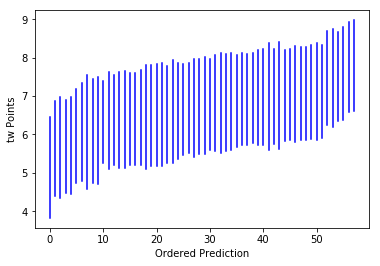

100%|██████████| 500/500 [00:00<00:00, 1588.11it/s]


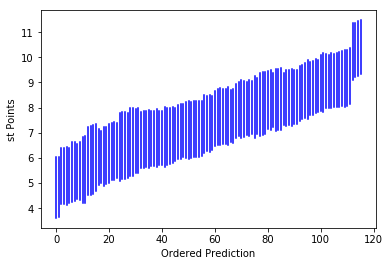

100%|██████████| 500/500 [00:00<00:00, 961.95it/s] 


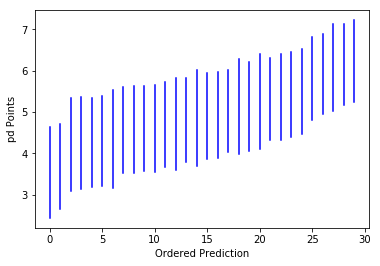

100%|██████████| 500/500 [00:00<00:00, 1987.80it/s]


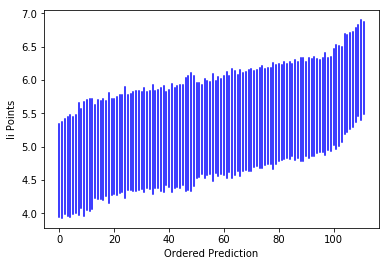

  0%|          | 1/500 [00:00<00:50,  9.86it/s]

11.5888350298


100%|██████████| 500/500 [00:00<00:00, 934.21it/s]


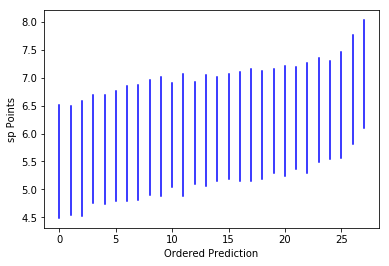

100%|██████████| 500/500 [00:00<00:00, 1005.59it/s]


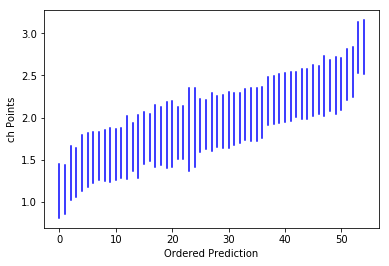

In [148]:
for elt_type in ELT_TYPES:
    elts = elts_worlds[elts_worlds.elt_type == elt_type]
    results[elt_type][2][0].set_value(np.asarray(elts.skater_code))
    results[elt_type][2][1].set_value(np.asarray(elts.log_overall_start))
    results[elt_type][2][2].set_value(np.asarray(elts.log_skater_start))
    
    ppc[elt_type] = pm.sample_ppc(trace=results[elt_type][0], model=results[elt_type][1], samples=500)['y_' + elt_type]

    mean = means[elt_type] = ppc[elt_type].mean(axis=0)
    std = np.std(ppc[elt_type], axis=0)
    order = pd.Series(mean).sort_values().index
    if elt_type == 'l2':
        print mean
        continue
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Prediction');
    plt.show()

100%|██████████| 500/500 [00:00<00:00, 1250.49it/s]


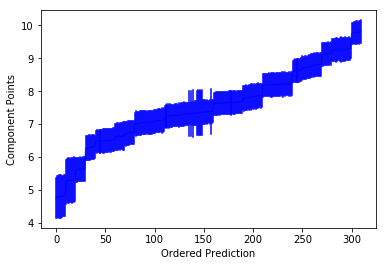

In [149]:
results['component'][2][0].set_value(np.asarray(comp_worlds.skater_code))
results['component'][2][1].set_value(np.asarray(comp_worlds.log_overall_start))
results['component'][2][2].set_value(np.asarray(comp_worlds.log_skater_start))

ppc_result = pm.sample_ppc(trace=results['component'][0], model=results['component'][1], samples=500)
ppc['component'] = ppc_result['y_comp']

mean = means['component'] = ppc['component'].mean(axis=0)
std = np.std(ppc['component'], axis=0)

# Sort actual point outcomes by order predicted by model.
real_outcomes = comp_worlds
order = pd.Series(mean).sort_values().index
plt.plot(xrange(len(mean)), [mean[x] for x in order])
for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
    plt.plot([i,i], [m-s, m+s], 'b-')
plt.ylabel('Component Points');plt.xlabel('Ordered Prediction');
plt.show()

In [150]:
elts_worlds['is_short'] = elts_worlds.apply(lambda row: 1 if 'short' in row.segment else 0, axis=1)

In [151]:
elt_predictions = elts_worlds[['element', 'elt_type', 'skater', 'skater_code', 'is_short']].copy()
comp_predictions = comp_worlds[['comp_type', 'component', 'skater', 'skater_code', 'is_short']].copy()

In [154]:
elt_pred_col = []
elt_indices = {elt_type: 0 for elt_type in ELT_TYPES}
for index, row in elt_predictions.iterrows():
    if row.elt_type == 'l2':
        elt_pred_col.append(means[row.elt_type])
        continue
    elt_pred_col.append(means[row.elt_type][elt_indices[row.elt_type]])
    elt_indices[row.elt_type] += 1

In [155]:
elt_predictions['prediction'] = elt_pred_col
comp_predictions['prediction_unfactored'] = means['component']

In [156]:
short_factor = 1.0 if DISCIPLINE == 'men' else 0.8
free_factor = 2.0 if DISCIPLINE == 'men' else 1.6
free_factor = 1.2 if DISCIPLINE == 'dance' else free_factor

In [158]:
comp_predictions['prediction'] = comp_predictions.apply(
    lambda row: row.prediction_unfactored * short_factor if row.is_short == 1 else row.prediction_unfactored * free_factor,
    axis=1
)

In [159]:
predictions = pd.concat([elt_predictions, comp_predictions])
predictions.to_csv('fits/worlds_predictions_' + DISCIPLINE + '.csv')

In [330]:
predictions = pd.read_csv('fits/worlds_predictions_men.csv')

In [331]:
short_rankings = predictions[predictions.is_short == 1].groupby('skater').prediction.sum().sort_values(ascending=False)

In [332]:
dnq = short_rankings[24:]

In [318]:
dnq['Stanislava KONSTANTINOVA'] = 180.
dnq['Alisa STOMAKHINA'] = 40.
dnq['Elisabetta LECCARDI'] = 50.

In [333]:
top24 = short_rankings[:24].index

In [334]:
top24 = predictions[predictions.skater.isin(top24)].groupby('skater').prediction.sum().sort_values(ascending=False)

In [335]:
top24

skater
Nathan CHEN             308.329612
Shoma UNO               295.941618
Boyang JIN              286.315187
Mikhail KOLYADA         268.531585
Dmitri ALIEV            261.828645
Vincent ZHOU            261.690619
Keiji TANAKA            248.443268
Max AARON               248.309641
Deniss VASILJEVS        243.382929
Michal BREZINA          240.090285
Nam NGUYEN              238.369752
Misha GE                236.168272
Keegan MESSING          235.479919
Kazuki TOMONO           232.432894
Alexei BYCHENKO         231.434236
Daniel SAMOHIN          230.965171
Matteo RIZZO            223.736666
Morisi KVITELASHVILI    216.526860
Alexander MAJOROV       215.240798
Jinseo KIM              213.719918
Paul FENTZ              212.610600
Brendan KERRY           211.548540
Phillip HARRIS          205.987983
Ivan PAVLOV             204.498309
Name: prediction, dtype: float64

In [336]:
predictions = pd.concat([top24, dnq])

In [337]:
predictions = predictions.sort_values(ascending=False)

In [338]:
predictions = pd.DataFrame(predictions)

In [339]:
predictions

prediction
skater                          
Nathan CHEN           308.329612
Shoma UNO             295.941618
Boyang JIN            286.315187
Mikhail KOLYADA       268.531585
Dmitri ALIEV          261.828645
Vincent ZHOU          261.690619
Keiji TANAKA          248.443268
Max AARON             248.309641
Deniss VASILJEVS      243.382929
Michal BREZINA        240.090285
Nam NGUYEN            238.369752
Misha GE              236.168272
Keegan MESSING        235.479919
Kazuki TOMONO         232.432894
Alexei BYCHENKO       231.434236
Daniel SAMOHIN        230.965171
Matteo RIZZO          223.736666
Morisi KVITELASHVILI  216.526860
Alexander MAJOROV     215.240798
Jinseo KIM            213.719918
Paul FENTZ            212.610600
Brendan KERRY         211.548540
Phillip HARRIS        205.987983
Ivan PAVLOV           204.498309
Julian Zhi Jie YEE     68.623104
Romain PONSART         67.716663
Javier RAYA            65.449135
Chih-I TSAO            64.879213
Stephane WALKER        63.005726
Abzal RAKIMGALIEV      62.137885
Donovan CARRILLO       61.454353
Slavik HAYRAPETYAN     61.265370
Igor REZNICHENKO       61.191209
Burak DEMIRBOGA        60.870224
Valtter VIRTANEN       60.041833
Nicholas VRDOLJAK      58.070186
Larry LOUPOLOVER       53.533934

In [340]:
predictions['rank'] = [i + 1 for i in xrange(len(predictions))]

In [341]:
predictions

prediction  rank
skater                                
Nathan CHEN           308.329612     1
Shoma UNO             295.941618     2
Boyang JIN            286.315187     3
Mikhail KOLYADA       268.531585     4
Dmitri ALIEV          261.828645     5
Vincent ZHOU          261.690619     6
Keiji TANAKA          248.443268     7
Max AARON             248.309641     8
Deniss VASILJEVS      243.382929     9
Michal BREZINA        240.090285    10
Nam NGUYEN            238.369752    11
Misha GE              236.168272    12
Keegan MESSING        235.479919    13
Kazuki TOMONO         232.432894    14
Alexei BYCHENKO       231.434236    15
Daniel SAMOHIN        230.965171    16
Matteo RIZZO          223.736666    17
Morisi KVITELASHVILI  216.526860    18
Alexander MAJOROV     215.240798    19
Jinseo KIM            213.719918    20
Paul FENTZ            212.610600    21
Brendan KERRY         211.548540    22
Phillip HARRIS        205.987983    23
Ivan PAVLOV           204.498309    24
Julian Zhi Jie YEE     68.623104    25
Romain PONSART         67.716663    26
Javier RAYA            65.449135    27
Chih-I TSAO            64.879213    28
Stephane WALKER        63.005726    29
Abzal RAKIMGALIEV      62.137885    30
Donovan CARRILLO       61.454353    31
Slavik HAYRAPETYAN     61.265370    32
Igor REZNICHENKO       61.191209    33
Burak DEMIRBOGA        60.870224    34
Valtter VIRTANEN       60.041833    35
Nicholas VRDOLJAK      58.070186    36
Larry LOUPOLOVER       53.533934    37

In [342]:
predictions.to_csv('fits/worlds_predictions_final_men.csv')